In [169]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




## Load Data

In [170]:
## import data

gdf = gpd.read_file("business_case_202505.shp")
df_fert = pd.read_csv("eda_fert.csv")
df_phyt = pd.read_csv("eda_phyt.csv")
df_field = pd.read_csv("cleaned_data_field.csv")
df_tillage = pd.read_csv("eda_tillage.csv")



## Clean df for merging

In [171]:
gdf.rename(columns={'farm_sea_1':'farm_season_field_id'}, inplace=True)
gdf.drop(columns=['crop_name','farm_sea_2','farm_seaso'], inplace=True)
df_field.drop(columns=['Unnamed: 0', 'farm_season_id'], inplace=True)


## Reset Index

In [172]:
gdf = gdf.set_index("farm_season_field_id")
df_field = df_field.set_index("farm_season_field_id")
df_fert = df_fert.set_index("farm_season_field_id")
df_tillage = df_tillage.set_index("farm_season_field_id")
df_phyt = df_phyt.set_index("farm_season_field_id")

In [173]:
print(gdf.index.nunique(), df_tillage.index.nunique(),df_phyt.index.nunique(),df_field.index.nunique(),df_fert.index.nunique())


168 130 92 168 83


## Merge

In [174]:
df_final = gdf \
    .join(df_fert, how='left') \
    .join(df_tillage, how='left') \
    .join(df_phyt, how='left') \
    .join(df_field, how='inner')


In [175]:
df_final.columns

Index(['area', 'geometry', 'fert_in_kg', 'number_of_passes', 'pesticide_in_kg',
       'programme_year', 'farm_season_field_name', 'has_cover_crops',
       'irrigated', 'organic_matter', 'soil_ph', 'declared_tillage_name',
       'field_permament_crop', 'crop_name', 'yield', 'em_ghg_total'],
      dtype='object')

In [176]:
key_columns = ['area', 'pesticide_in_kg','fert_in_kg', 'programme_year','farm_season_field_name','crop_name', 'yield', 'em_ghg_total','geometry' ]

In [177]:
df_final = df_final[key_columns]
df_final

,area,pesticide_in_kg,fert_in_kg,programme_year,farm_season_field_name,crop_name,yield,em_ghg_total,geometry
farm_season_field_id,,,,,,,,,
16515.0,0.290,NaN,NaN,1,Champ 0,Permanent pasture,0.0,NaN,"POLYGON ((1.55277 43.30601, 1.55278 43.306, 1...."
16516.0,5.390,23.555,700.9,1,SB,Grain corn,12.6,1.189420,"POLYGON ((1.55278 43.306, 1.55277 43.30601, 1...."
16517.0,0.080,NaN,NaN,1,Champ 2,Permanent pasture,0.0,NaN,"POLYGON ((1.55277 43.30601, 1.55271 43.30598, ..."
16518.0,12.130,7.574,230.0,1,POMP,Durum winter wheat,5.3,2.068320,"POLYGON ((1.56368 43.29696, 1.56399 43.29678, ..."
16519.0,10.040,23.555,700.9,1,PIV1,Grain corn,12.6,1.158030,"POLYGON ((1.56145 43.30061, 1.56146 43.30061, ..."
...,...,...,...,...,...,...,...,...,...
360943.0,3.940,19.225,494.0,4,Tram,Grain corn,12.2,0.425221,"POLYGON ((1.56217 43.30094, 1.56308 43.30166, ..."
360944.0,1.970,19.225,494.0,4,Trame,Grain corn,12.2,0.461348,"POLYGON ((1.56146 43.30063, 1.56216 43.30093, ..."
360945.0,9.100,19.225,494.0,4,LONG 1,Grain corn,12.2,0.442063,"POLYGON ((1.56994 43.30211, 1.5717 43.30438, 1..."


## Normalisation by hectare

In [178]:
## normalise by hectare
df_final['fert_kg'] = df_final['fert_in_kg'] / df_final['area']
df_final['pesticide_kg'] = df_final['pesticide_in_kg'] / df_final['area']
df_final['em_ghg_total'] = df_final['em_ghg_total'] / df_final['area']


## Map plot

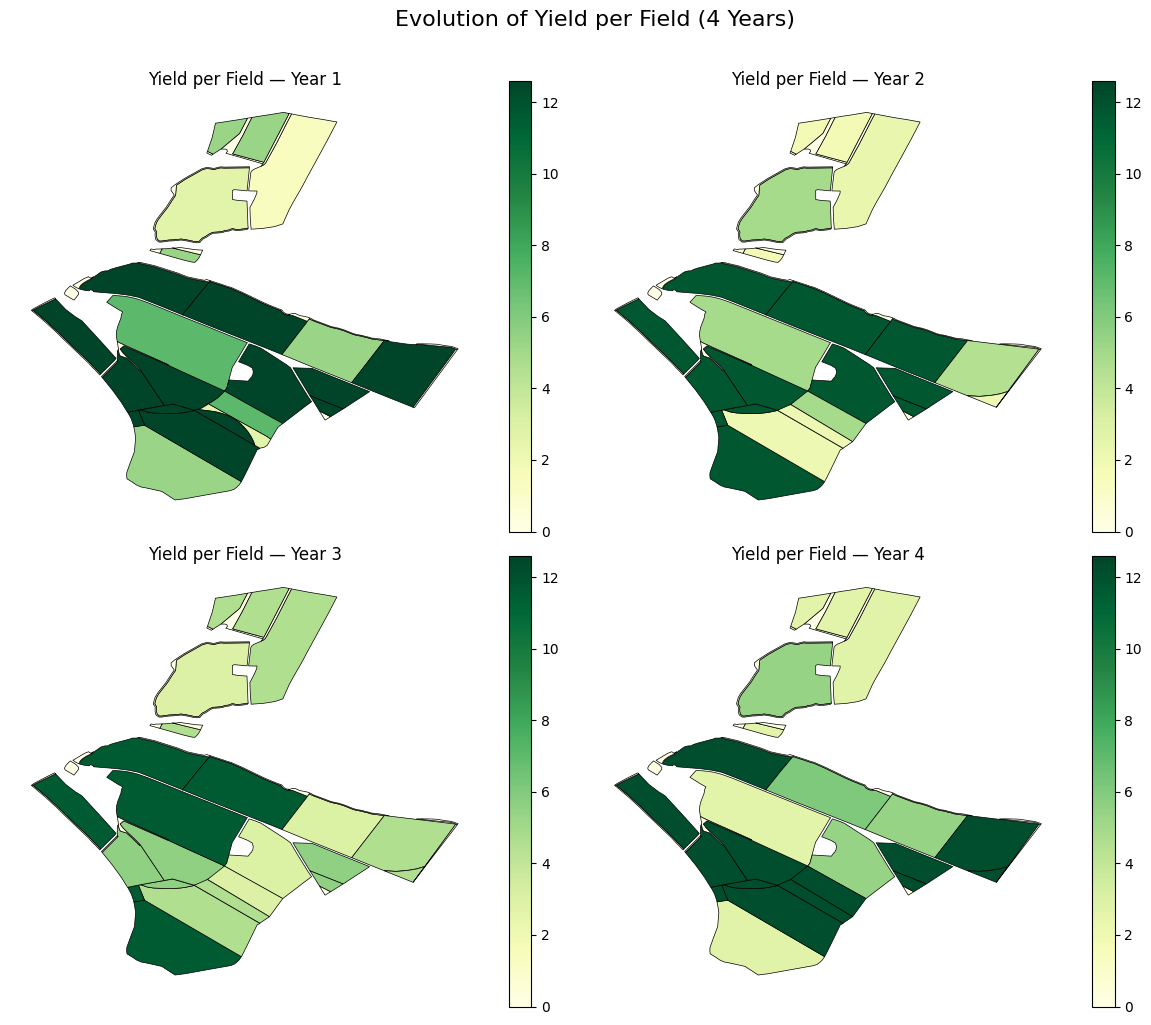

In [218]:

# Make sure df_only_wheat is a GeoDataFrame
gdf = gpd.GeoDataFrame(df_final, geometry='geometry')

# Set consistent min/max for color scale
vmin = gdf['yield'].min()
vmax = gdf['yield'].max()

# Get all programme years
years = sorted(gdf['programme_year'].unique())

# Create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot yield per year
for i, year in enumerate(years):
    ax = axes[i]
    gdf_year = gdf[gdf['programme_year'] == year]

    gdf_year.plot(
        column='yield',
        cmap='YlGn',
        linewidth=0.5,
        edgecolor='black',
        legend=True,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No data"}
    )

    ax.set_title(f"Yield per Field — Year {year}")
    ax.axis('off')

plt.suptitle("Evolution of Yield per Field (4 Years)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Average per year

In [191]:
df_final.dropna()

,area,pesticide_in_kg,fert_in_kg,programme_year,farm_season_field_name,crop_name,yield,em_ghg_total,geometry,fert_kg,pesticide_kg
farm_season_field_id,,,,,,,,,,,
16516.0,5.39,23.555,700.9,1,SB,Grain corn,12.6,0.220672,"POLYGON ((1.55278 43.306, 1.55277 43.30601, 1....",130.037106,4.370130
16518.0,12.13,7.574,230.0,1,POMP,Durum winter wheat,5.3,0.170513,"POLYGON ((1.56368 43.29696, 1.56399 43.29678, ...",18.961253,0.624402
16519.0,10.04,23.555,700.9,1,PIV1,Grain corn,12.6,0.115342,"POLYGON ((1.56145 43.30061, 1.56146 43.30061, ...",69.810757,2.346116
16520.0,0.78,23.555,700.9,1,arrondi PIV2,Grain corn,12.6,1.484641,"POLYGON ((1.55853 43.30064, 1.55864 43.30066, ...",898.589744,30.198718
16521.0,0.43,23.555,700.9,1,pomp,Grain corn,12.6,2.734581,"POLYGON ((1.55877 43.29982, 1.5582 43.29973, 1...",1630.000000,54.779070
...,...,...,...,...,...,...,...,...,...,...,...
360941.0,1.83,24.490,88.0,4,FF,Sunflower,2.7,-0.305963,"POLYGON ((1.56289 43.3147, 1.56288 43.3147, 1....",48.087432,13.382514
360943.0,3.94,19.225,494.0,4,Tram,Grain corn,12.2,0.107924,"POLYGON ((1.56217 43.30094, 1.56308 43.30166, ...",125.380711,4.879442
360944.0,1.97,19.225,494.0,4,Trame,Grain corn,12.2,0.234187,"POLYGON ((1.56146 43.30063, 1.56216 43.30093, ...",250.761421,9.758883


In [192]:
numeric_cols_num = ['yield','fert_kg','pesticide_kg','em_ghg_total','programme_year']
df_average = df_final[numeric_cols_num ].groupby('programme_year').mean()
df_average

,yield,fert_kg,pesticide_kg,em_ghg_total
programme_year,,,,
1,5.030952,290.286265,9.862962,0.511974
2,4.164286,227.687513,6.514164,0.200311
3,3.492381,213.235401,5.333511,0.328195
4,4.697619,208.126176,8.913965,0.097438


In [221]:
## calculate yield stability :

yield_values = df_average['yield'].dropna()

mean_yield = yield_values.mean()
std_yield = yield_values.std()

stability_score = 1 - (std_yield / mean_yield)
print(f"Yield Stability Score: {stability_score:.2f}")

Yield Stability Score: 0.85


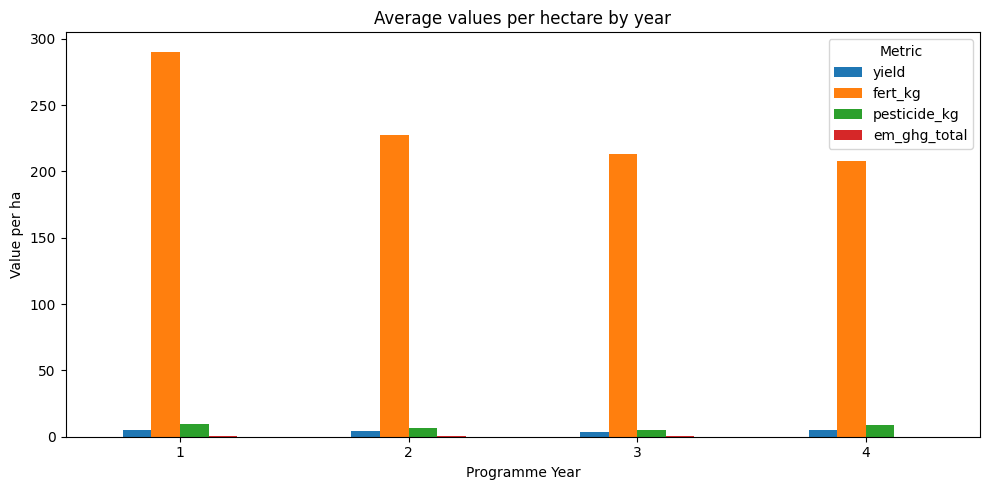

In [193]:
df_average.plot(kind='bar', figsize=(10, 5))
plt.title("Average values per hectare by year")
plt.xlabel("Programme Year")
plt.ylabel("Value per ha")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


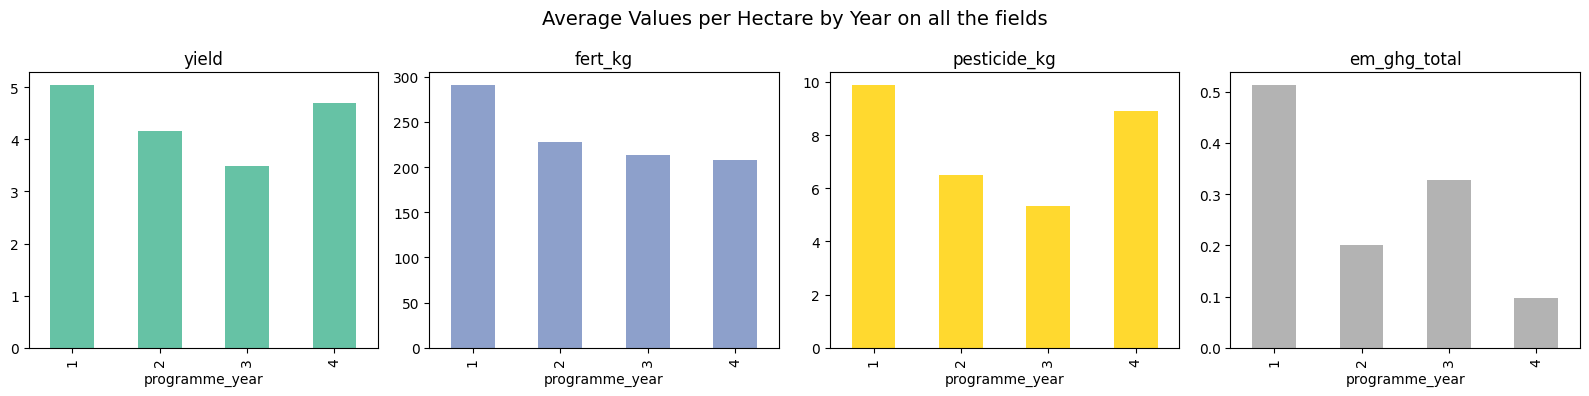

In [213]:
import matplotlib.pyplot as plt

# Ensure 'programme_year' is the index
df_plot = df_average.copy()
df_plot.index.name = 'programme_year'

# Plot with separate axes (1 row × 4 columns)
df_plot.plot(
    kind='bar',
    subplots=True,
    layout=(1, 4),  # 1 row, 4 columns
    figsize=(16, 4),
    sharex=True,
    sharey=False,
    legend=False,
    colormap='Set2'
)

plt.suptitle("Average Values per Hectare by Year on all the fields", fontsize=14)
plt.tight_layout()
plt.show()


## At least one wheat field over the four years

In [182]:
# All field names that had wheat at least once
wheat_fields = df_final[df_final['crop_name'].str.contains('wheat', case=False, na=False)]['farm_season_field_name'].unique()
wheat_fields


array(['POMP', 'PH5', 'SM', 'FM', 'FF', 'BOUL', 'MONT', 'Tram', 'PIV1',
       'MONT EST', 'Trame', 'LONG 1', 'LONG 2', 'TRAM'], dtype=object)

In [183]:
# Keep all rows where the field name is in that list
df_one_wheat = df_final[df_final['farm_season_field_name'].isin(wheat_fields)]
df_one_wheat.shape

(53, 11)

## Only wheat fields

In [194]:
before = len(df_final)
df_only_wheat = df_final[df_final['crop_name'] == 'Durum winter wheat']
after = len(df_only_wheat)
print(f"Dropped {before - after} rows")

Dropped 149 rows


In [195]:
df_only_wheat.drop(columns=['crop_name'], inplace=True)

<ipython-input-195-2a43f5f1524a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_wheat.drop(columns=['crop_name'], inplace=True)


In [198]:
df_only_wheat.shape

(19, 10)

In [199]:
df_only_wheat

,area,pesticide_in_kg,fert_in_kg,programme_year,farm_season_field_name,yield,em_ghg_total,geometry,fert_kg,pesticide_kg
farm_season_field_id,,,,,,,,,,
16518.0,12.13,7.574,230.0,1,POMP,5.30,0.170513,"POLYGON ((1.56368 43.29696, 1.56399 43.29678, ...",18.961253,0.624402
16539.0,9.00,7.574,477.0,1,PH5,5.30,0.239518,"POLYGON ((1.57139 43.30399, 1.56993 43.30211, ...",53.000000,0.841556
16546.0,0.82,10.650,183.0,1,SM,5.30,1.534024,"POLYGON ((1.56177 43.30895, 1.56168 43.30879, ...",223.170732,12.987805
16554.0,4.00,10.650,430.0,1,FM,5.30,0.365130,"POLYGON ((1.56456 43.3164, 1.56461 43.31641, 1...",107.500000,2.662500
16556.0,1.83,10.650,680.0,1,FF,5.30,0.840579,"POLYGON ((1.56289 43.3147, 1.56288 43.3147, 1....",371.584699,5.819672
43615.0,16.79,9.440,715.3,2,BOUL,4.90,0.070323,"POLYGON ((1.5573 43.30433, 1.55728 43.30443, 1...",42.602740,0.562239
43640.0,13.08,9.440,413.0,2,MONT,4.90,0.071557,"POLYGON ((1.56045 43.31222, 1.56049 43.3127, 1...",31.574924,0.721713
44016.0,3.94,9.440,747.9,2,Tram,4.90,0.332257,"POLYGON ((1.56217 43.30094, 1.56308 43.30166, ...",189.822335,2.395939
125012.0,10.04,9.585,478.0,3,PIV1,4.61,0.036430,"POLYGON ((1.56145 43.30062, 1.56146 43.30061, ...",47.609562,0.954681


## Plotting wheat fields on the map

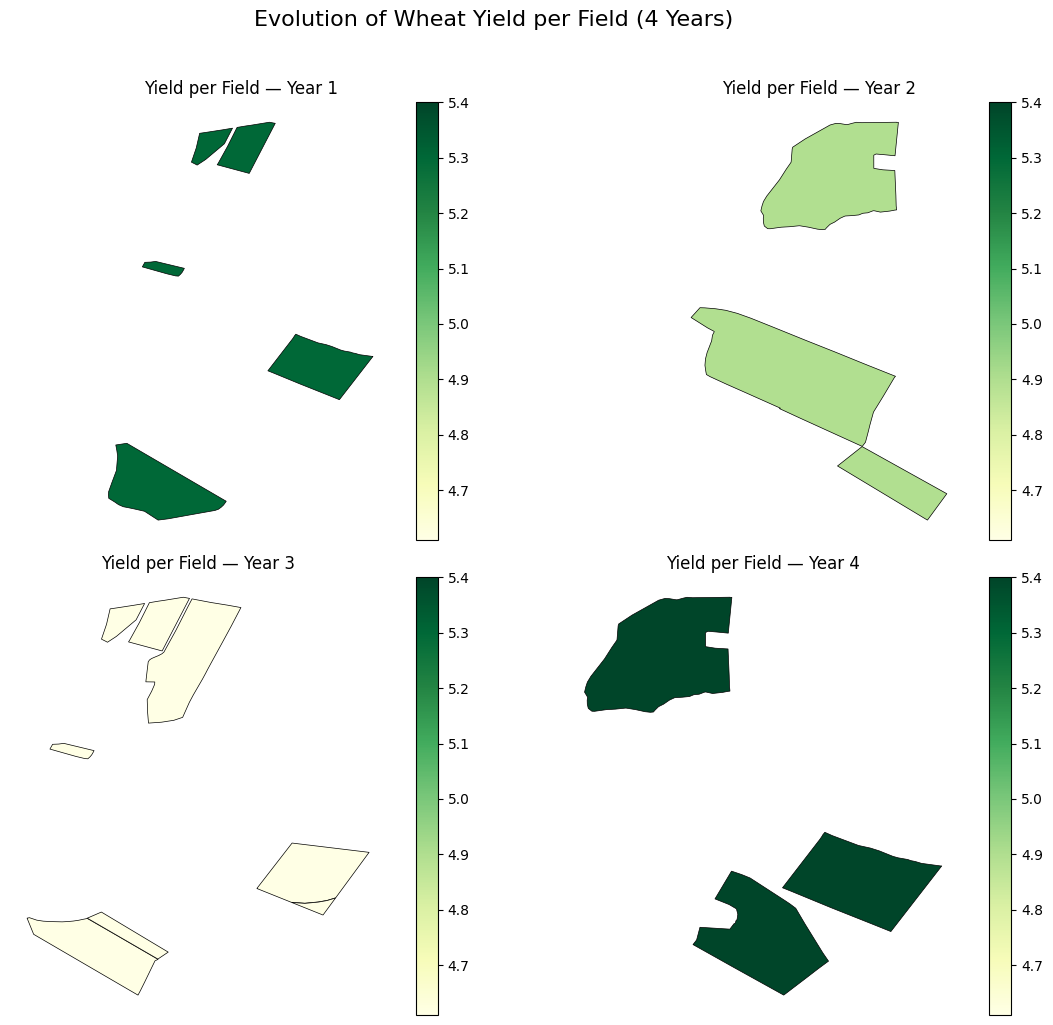

In [219]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Make sure df_only_wheat is a GeoDataFrame
gdf = gpd.GeoDataFrame(df_only_wheat, geometry='geometry')

# Set consistent min/max for color scale
vmin = gdf['yield'].min()
vmax = gdf['yield'].max()

# Get all programme years
years = sorted(gdf['programme_year'].unique())

# Create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot yield per year
for i, year in enumerate(years):
    ax = axes[i]
    gdf_year = gdf[gdf['programme_year'] == year]

    gdf_year.plot(
        column='yield',
        cmap='YlGn',
        linewidth=0.5,
        edgecolor='black',
        legend=True,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No data"}
    )

    ax.set_title(f"Yield per Field — Year {year}")
    ax.axis('off')

plt.suptitle("Evolution of Wheat Yield per Field (4 Years)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Averaging wheat field over the years

In [187]:
## average
df_average_only_wheat = df_only_wheat[numeric_cols_num ].groupby('programme_year').mean()
df_average_only_wheat

,yield,fert_kg,pesticide_kg,em_ghg_total
programme_year,,,,
1,5.30,154.843337,4.587187,0.629953
2,4.90,87.999999,1.226630,0.158046
3,4.61,221.496658,4.278102,0.458685
4,5.40,52.824817,1.133320,0.066594


In [220]:
## calculate yield stability :

yield_values = df_average_only_wheat['yield'].dropna()

mean_yield = yield_values.mean()
std_yield = yield_values.std()

stability_score = 1 - (std_yield / mean_yield)
print(f"Yield Stability Score: {stability_score:.2f}")


Yield Stability Score: 0.93


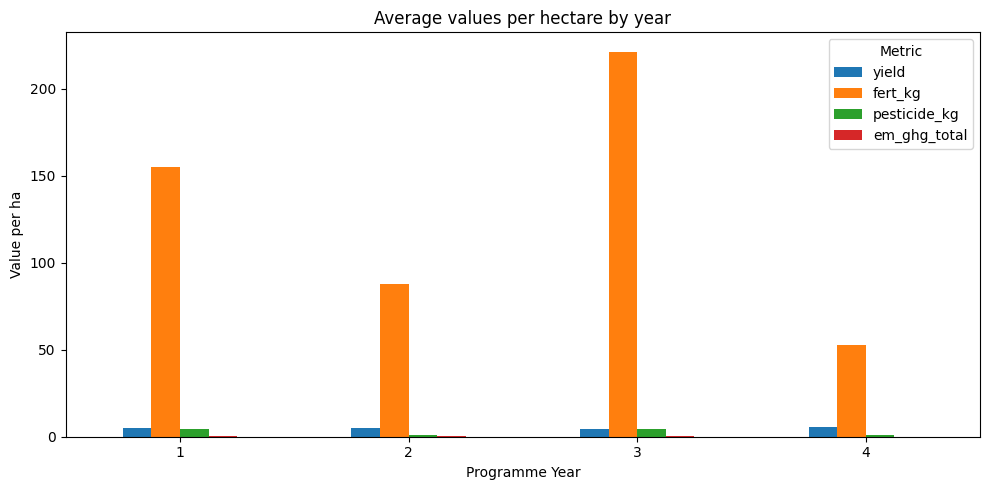

In [188]:
df_average_only_wheat.plot(kind='bar', figsize=(10, 5))
plt.title("Average values per hectare by year")
plt.xlabel("Programme Year")
plt.ylabel("Value per ha")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

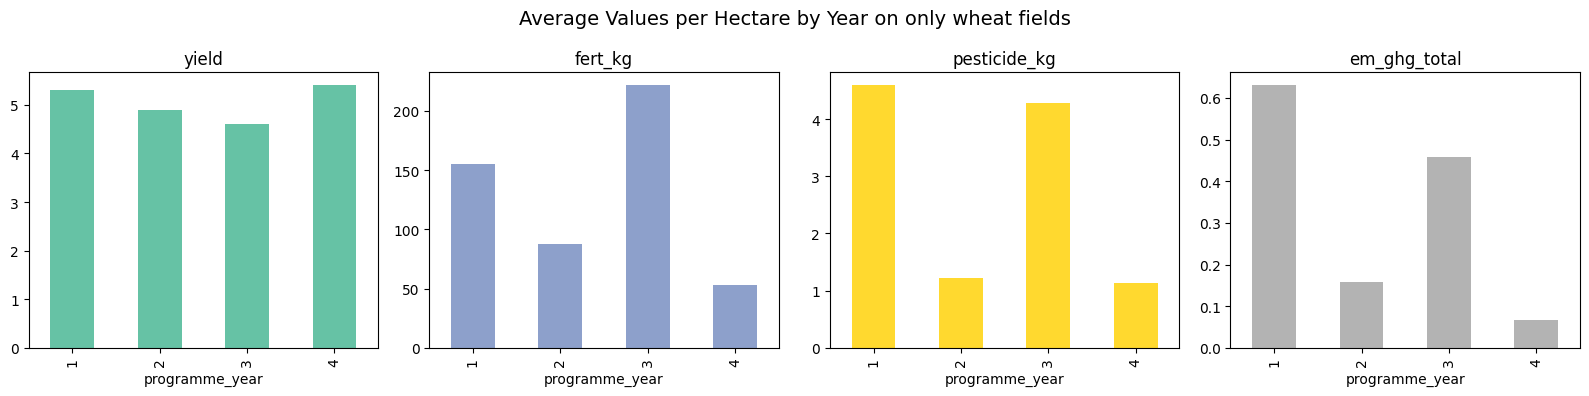

In [215]:
import matplotlib.pyplot as plt

# Ensure 'programme_year' is the index
df_plot = df_average_only_wheat.copy()
df_plot.index.name = 'programme_year'

# Plot with separate axes (1 row × 4 columns)
df_plot.plot(
    kind='bar',
    subplots=True,
    layout=(1, 4),  # 1 row, 4 columns
    figsize=(16, 4),
    sharex=True,
    sharey=False,
    legend=False,
    colormap='Set2'
)

plt.suptitle("Average Values per Hectare by Year on only wheat fields", fontsize=14)
plt.tight_layout()
plt.show()


## Pair plotting and correlation

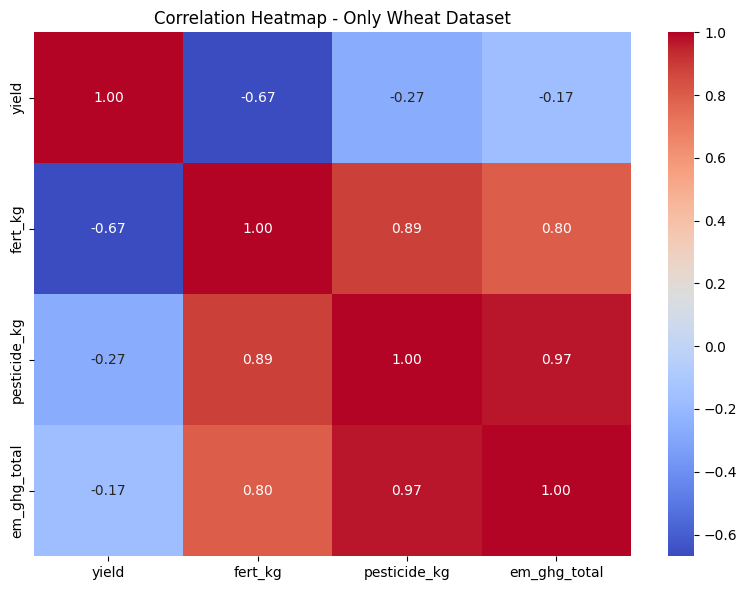

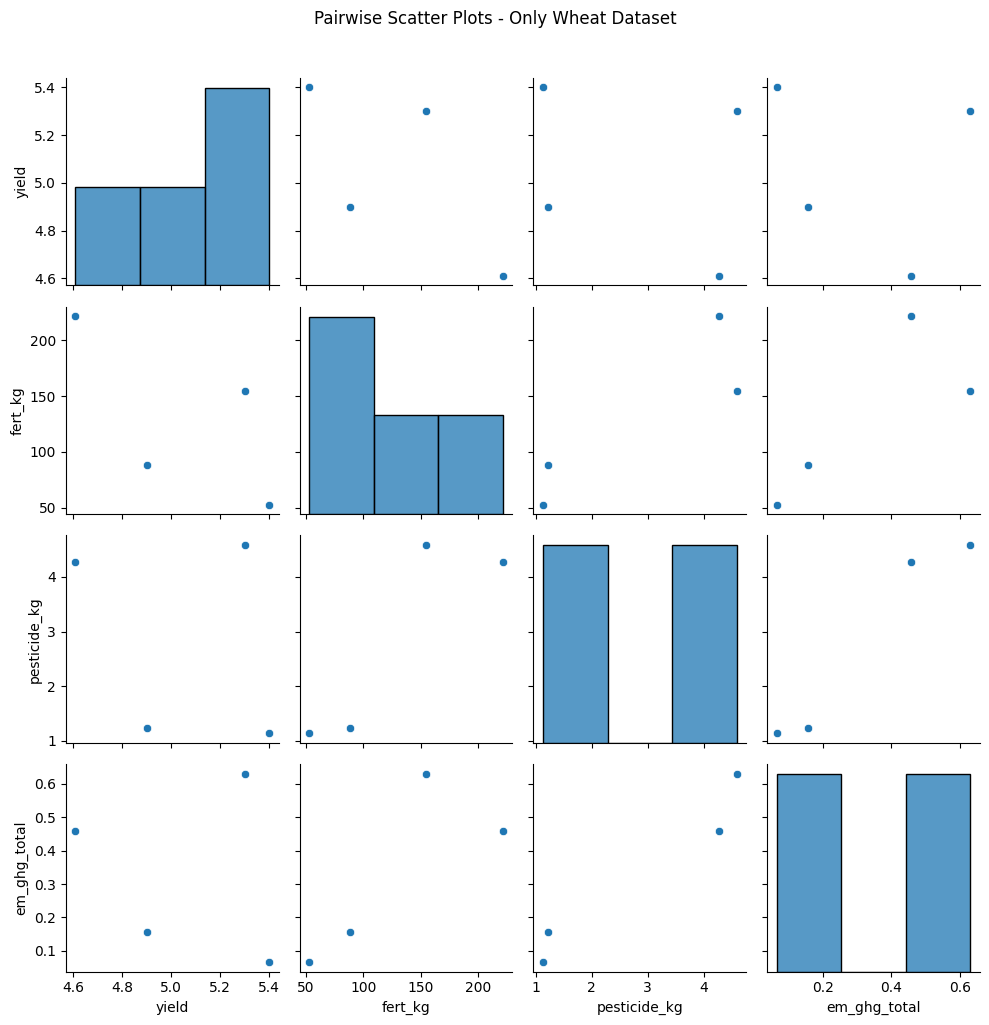

In [189]:

# Correlation
plt.figure(figsize=(8, 6))
corr_matrix = df_average_only_wheat.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap - Only Wheat Dataset")
plt.tight_layout()
plt.show()

# Pairplot
sns.pairplot(df_average_only_wheat)
plt.suptitle("Pairwise Scatter Plots - Only Wheat Dataset", y=1.02)
plt.tight_layout()
plt.show()



## Covariance and metrics

In [208]:
# Drop missing values just in case
df_clean = df_average_only_wheat.dropna()

# Target variable
target = 'yield'
other_vars = ['fert_kg', 'pesticide_kg', 'em_ghg_total']

# Compute covariances
for var in other_vars:
    cov = df_clean[[target, var]].cov().iloc[0, 1]
    print(f"Covariance(yield, {var}): {cov:.4f}")



Covariance(yield, fert_kg): -18.2506
Covariance(yield, pesticide_kg): -0.1837
Covariance(yield, em_ghg_total): -0.0160
